# Homework 1: Text Classification
## Due Date: Mon, Sep 16, 2024, 11:59 PM EST
- **Overview**: For this assignment, we’ll be building a text classifier. The goal of our text classifer will be to distinguish between words that are simple and words that are complex. Example simple words are `heard`, `sat`, and `town`, and example complex words are `abdicate`, `detained`, and `vintners`. Distinguishing between simple and complex words is the first step in a larger NLP task called text simplification, which aims to replace complex words with simpler synonyms. Text simplification is potentially useful for re-writing texts so that they can be more easily understood by younger readers, people learning English as a second language, or people with learning disabilities.

- **Learning goals**:
    - Understand an important class of NLP evaluation methods (precision, recall and F1), and implement them yourself.
    - Employ common experimental design practices in NLP. Split the annotated data into training/development/test sets, implement simple baselines to determine how difficult the task is, and experiment with a range of features and models.
    - Get an introduction to `sklearn`, an excellent machine learning Python package.

- **Data**: We will provide you with training and development data that has been manually labeled. We will also give you a test set without labels. You will build a classifier to predict the labels on our test set. You can upload your classifier’s predictions to Gradescope. We will score its predictions and maintain a leaderboard showing whose classifier has the best performance.

## Recommended Readings
- [Naive Bayes Classification and Sentiment](https://web.stanford.edu/~jurafsky/slp3/4.pdf) Dan Jurafsky and James H. Martin. Speech and Language Processing (3rd edition draft).
- [Logistic Regression](https://web.stanford.edu/~jurafsky/slp3/5.pdf) Dan Jurafsky and James H. Martin. Speech and Language Processing (3rd edition draft) .
- [Problems in Current Text Simplification Research: New Data Can Help](http://www.cis.upenn.edu/~ccb/publications/new-data-for-text-simplification.pdf) Wei Xu, Chris Callison-Burch, and Courtney Napoles. TACL 2015.
- [Comparison of Techniques to Automatically Identify Complex Words](http://aclweb.org/anthology/P/P13/P13-3015.pdf) Matthew Shardlow. ACL 2013.
- [SemEval 2016 Task 11: Complex Word Identification](https://www.researchgate.net/profile/Gustavo_Paetzold/publication/305334627_SemEval_2016_Task_11_Complex_Word_Identification/links/57bab70a08ae14f440bd9722/SemEval-2016-Task-11-Complex-Word-Identification.pdf) Gustavo Paetzold and Lucia Specia. ACL 2016.

## Setup 1: PennGrader Setup

In [1]:
## DO NOT CHANGE ANYTHING, JUST RUN
# %%capture
!pip install penngrader-client dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00


In [2]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'


Writing notebook-config.yaml


In [3]:
!cat notebook-config.yaml


grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'


In [4]:
from penngrader.grader import *

## TODO - Start
STUDENT_ID = 72377337 # YOUR PENN-ID GOES HERE AS AN INTEGER#
## TODO - End

SECRET = STUDENT_ID
grader = PennGrader('notebook-config.yaml', 'cis5300_fa2024_HW1', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 72377337

Make sure this correct or we will not be able to store your grade


In [5]:
def reload_grader():
    grader = PennGrader('notebook-config.yaml', 'cis5300_fa2024_HW1', STUDENT_ID, SECRET)
    return grader

In [6]:
# check if the PennGrader is set up correctly
# do not change this cell, see if you get 4/4 (Mark gives 2/4, showing the grading is working but that you haven't changed the info yet)!
name_str = 'Yuanzhe Liu'
grader.grade(test_case_id = 'name_test', answer = name_str)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Setup 2: Dataset / Packages
- **Run the following cells without changing anything!**
- [Loading dataset from huggingface](https://huggingface.co/docs/datasets/v1.8.0/loading_datasets.html#from-local-files)

In [7]:
from collections import defaultdict
import gzip

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import numpy as np
from tqdm import tqdm

In [8]:
%%capture
# data
!gdown 1np28I4b1Q1K6K49oiVx3hqEoh-KMbSml #dev https://drive.google.com/file/d/1np28I4b1Q1K6K49oiVx3hqEoh-KMbSml/view?usp=drive_link
!gdown 1qu6CELzKzRM2x6qvyuaX5SWPIleHDfs6 # unlabeled https://drive.google.com/file/d/1qu6CELzKzRM2x6qvyuaX5SWPIleHDfs6/view?usp=drive_link
!gdown 1JL7UK17loFTOf0WW5mLZgZMTWXZq3THW # train https://drive.google.com/file/d/1JL7UK17loFTOf0WW5mLZgZMTWXZq3THW/view?usp=drive_link
!gdown 1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z # https://drive.google.com/file/d/1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z/view?usp=sharing
!curl -L -o ngram_counts.txt.gz http://www.cis.upenn.edu/~cis5300/18sp/data/ngram_counts.txt.gz

In [9]:
!gdown 1rkYaFae_qJk1AlHORDLH3aPH47f9DA8s

Downloading...
From (original): https://drive.google.com/uc?id=1rkYaFae_qJk1AlHORDLH3aPH47f9DA8s
From (redirected): https://drive.google.com/uc?id=1rkYaFae_qJk1AlHORDLH3aPH47f9DA8s&confirm=t&uuid=729e10ce-898c-4914-86ac-b1c9e03bc61e
To: /content/ngram_counts.txt.gz
100% 44.5M/44.5M [00:00<00:00, 111MB/s]


In [51]:
train_file = "complex_words_training.txt"
dev_file = "complex_words_development.txt"
test_file = "complex_words_test_unlabeled.txt"
mini_test_file = 'complex_words_test_mini.txt'

In [52]:
########## DO NOT CHANGE ##########
## Loads in the words and labels of one of the datasets
def load_labeled_file(data_file):
    words = []
    labels = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

def load_unlabeled_file(data_file):
    words = []
    # labels = []
    with open(data_file, 'rt', encoding="utf8") as f:
        words = [line.strip() for line in f.readlines() if len(line.strip()) > 0]
    return words

def load_test_file(data_file):
    words = []
    with open(data_file, 'rt', encoding="utf8") as f:
        next(f) # skip first line (header)
        words = [line.strip().split('\t')[0] for line in f.readlines() if len(line.strip()) > 0]
    return words

## Loads Google NGram counts
def load_ngram_counts(ngram_counts_file = 'ngram_counts.txt.gz'):
    counts = defaultdict(int)
    with gzip.open(ngram_counts_file, 'rt') as f:
        for line in f:
            token, count = line.strip().split('\t')
            if token[0].islower():
                counts[token] = int(count)
    return counts
ngram_counts = load_ngram_counts()

### About the data
- `train_data`, `dev_data`: these are words with labels, provided for you to train and evaluate your models.
- `mini_test_words`: this is a subset (50) of the unseen test dataset, we will provide test the **basic functionality** of your models based on the performance on this mini testset (PennGrader tests). **This would only be a basic sanity check of your implementation. The final grade would be based on the PennGrader Grades and manual grading on your implementation**
- `test_words`: this is the full, unlabelled test set. You are expected to submit the prediction of these words at the end of the assignment.

In [54]:
########## DO NOT CHANGE ##########
train_data = load_labeled_file(train_file)
dev_data = load_labeled_file(dev_file)
mini_test_words = load_unlabeled_file(mini_test_file)
test_words = load_test_file(test_file)

# you can take a look at this mini-dev data by uncommenting this line
dev_words, dev_labels = dev_data
dev_words[:5] # some examples of this dev dataset

['hammer', 'renewable', 'showings', 'academy', 'continues']

In [55]:
mini_test_words[:5]

['threads', 'reinforce', 'letters', 'pioneered', 'closer']

# Section 1. Implement the Evaluation Metrics
- You might find this [Wikipedia Page](https://en.wikipedia.org/wiki/Precision_and_recall) useful.
- **Problem 1.1** Predicion, Recall, F1 Score

In [56]:
## Input: y_pred, a list of length n with the predicted labels,
## y_true, a list of length n with the true labels

## Calculates the precision of the predicted labels
def get_precision(y_true, y_pred):
    true_positive = len([1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 1])
    false_positive = len([1 for true, pred in zip(y_true, y_pred) if true == 0 and pred == 1])
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
    return precision

## Calculates the recall of the predicted labels
def get_recall(y_true, y_pred):
    true_positive = len([1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 1])
    false_negative = len([1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 0])
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    return recall

## Calculates the f-score of the predicted labels
def get_fscore(y_true, y_pred):
    precision = get_precision(y_true, y_pred)
    recall = get_recall(y_true, y_pred)
    fscore = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return fscore

In [57]:
#DO NOT CHANGE!

from dill.source import getsource
grader.grade(test_case_id = 'test_q11_eval_funcs', answer = (getsource(get_precision), getsource(get_recall), getsource(get_fscore)))

Correct! You earned 12/12 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Section 2. Baselines

## 2.1 Implement a majority class baseline
You should start by implementing simple baselines as classifiers. Your first baseline is a **majority class baseline** which is one of the most simple classifier. You should complete the function `all_complex(words)`, which takes in a list of words, and returns out the predictions.


- **Problem 2.1:** Implement `all_complex()` that always predicts the majority class of the data (i.e. predicting every word as complex)

In [58]:
## Labels every word complex
def all_complex(words):
    ## YOUR CODE HERE...
    y_pred = [1] * len(words)
    return y_pred

- **Answer 2.1:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Training: Precision: 0.43275; Recall: 1.0; F-score: 0.604083057058105
    - Development: Precision: 0.418; Recall: 1.0; F-score: 0.5895627644569816


In [59]:
words, labels = train_data
t_pred = all_complex(words)
precision = get_precision(labels, t_pred)
recall = get_recall(labels, t_pred)
fscore = get_fscore(labels, t_pred)
print('Training Data')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-score: {fscore}")

words, labels = dev_data
d_pred = all_complex(words)
precision = get_precision(labels, d_pred)
recall = get_recall(labels, d_pred)
fscore = get_fscore(labels, d_pred)
print('\nDevelopment Data')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-score: {fscore}")

Training Data
Precision: 0.43275
Recall: 1.0
F-score: 0.604083057058105

Development Data
Precision: 0.418
Recall: 1.0
F-score: 0.5895627644569816


In [60]:
# PennGrader - DO NOT CHANGE
all_complex_pred = all_complex(mini_test_words)
grader.grade(test_case_id = 'test_baseline_q21', answer = all_complex_pred)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 2.2 Word length baseline
For our next baseline, we will use a slightly complex baseline, the length of each word to predict its complexity.

For the word length baseline, you should try setting various thresholds for word length to classify them as simple or otherwise. For example, you might set a threshold of 9, meaning that any words with less than 9 characters will be labeled simple, and any words with 9 characters or more will be labeled complex. Once you find the best threshold using the training data, use this same threshold for the development data as well.

You will be filling in the function `word_length_threshold(train_data, dev_data)`. This function takes in both the training and development datasets, finds the best threshold on word length and returns out the predictions on development data for your best threshold.

Usually, Precision and Recall are inversely related and while building binary-classification systems we try to find a good balance between them (by maximizing f-score, for example). It is often useful to plot the Precision-Recall curve for various settings of the classifier to gauge its performance and compare it to other classifiers. For example, for this baseline, a Precision-Recall curve can be plotted by plotting the Precision (on the y-axis) and Recall (on the X-axis) for different values of word-length threshold.

- **Problem 2.2:** Implement `word_length_threshold()` that finds the best word length threshold and makes predictions on the development (or testing) data.

In [92]:
### 2.2: Word length thresholding
## Makes feature matrix for word_length_threshold
def length_threshold_feature(words, threshold):
    # return predictions based on the threshold
    predictions = []
    for word in words:
      if len(word) < threshold:
        predictions.append(0)
      else:
        predictions.append(1)
    return predictions

## Finds the best length threshold by f-score, and uses this threshold to
## classify the training and development set
def word_length_threshold(train_data, dev_data):
    twords, tlabels = train_data
    thresholds = range(max(len(word) for word in twords) + 1)
    best_threshold = 0
    cur_fscore = 0
    for threshold in thresholds:
      t_pred = length_threshold_feature(twords, threshold)
      f1 = get_fscore(tlabels, t_pred)
      if f1 > cur_fscore:
        cur_fscore = f1
        best_threshold = threshold
    print(best_threshold)
    # development dataset
    dev_pred = length_threshold_feature(dev_data, best_threshold)
    return dev_pred

- **Answer 2.2:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Range of thresholds: The range of thresholds is [1,20], the best thresholds is 7
    - Training: Precision: 0.6007401315789473; Recall: 0.8440207972270364; F1 Score: 0.7018976699495555
    - Development: Precision: 0.6053511705685619; Recall: 0.8660287081339713; F1 Score: 0.7125984251968505
    - Precision-recall Curve **[Plot below]**
        - For plotting, [matplotlib](https://matplotlib.org/) is a useful python library


In [99]:
# Training Data
twords, tlabels = train_data
y_pred = word_length_threshold(train_data, twords)
tprecision = get_precision(tlabels, y_pred)
trecall = get_recall(tlabels, y_pred)
tfscore = get_fscore(tlabels, y_pred)
print('Training Data')
print(f"Precision: {tprecision}")
print(f"Recall: {trecall}")
print(f"F1 Score: {tfscore}")

# Development Data
dwords, dlabels = dev_data
d_pred = word_length_threshold(train_data, dwords)
dprecision = get_precision(dlabels, d_pred)
drecall = get_recall(dlabels, d_pred)
dfscore = get_fscore(dlabels, d_pred)
# Report the precision, recall, and f-score on the development data
print('\nDevelopment Data')
print(f"Precision: {dprecision}")
print(f"Recall: {drecall}")
print(f"F1 Score: {dfscore}")

7
Training Data
Precision: 0.6007401315789473
Recall: 0.8440207972270364
F1 Score: 0.7018976699495555
7

Development Data
Precision: 0.6053511705685619
Recall: 0.8660287081339713
F1 Score: 0.7125984251968505


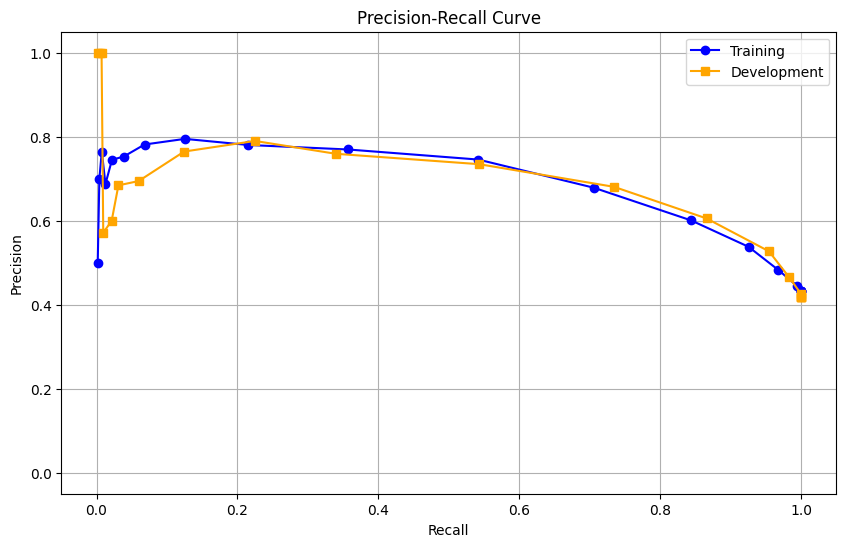

In [95]:
import matplotlib.pyplot as plt

# Training ～ precision-recall
twords, tlabels = train_data
thresholds = range(20)
train_precisions = []
train_recalls = []
for threshold in thresholds:
    t_pred = length_threshold_feature(twords, threshold)
    train_precisions.append(get_precision(tlabels, t_pred))
    train_recalls.append(get_recall(tlabels, t_pred))

# Development ～ precision-recall
dwords, dlabels = dev_data
dev_precisions = []
dev_recalls = []
for threshold in thresholds:
    d_pred = length_threshold_feature(dwords, threshold)
    dev_precisions.append(get_precision(dlabels, d_pred))
    dev_recalls.append(get_recall(dlabels, d_pred))

plt.figure(figsize=(10, 6))
plt.plot(train_recalls, train_precisions, marker='o', label='Training', color='blue')  # Training data in blue
plt.plot(dev_recalls, dev_precisions, marker='s', label='Development', color='orange')  # Dev data in orange
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(-0.05, 1.05)
plt.xlim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.show()

In [96]:
# PennGrader - DO NOT CHANGE
word_length_pred = word_length_threshold(train_data, mini_test_words)
grader.grade(test_case_id = 'test_baseline_q22', answer = word_length_pred)

7
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 2.3 Word frequency baseline


Our final baseline is a classifier similar to the last one, but thresholds on word frequency instead of length. We have provided Google NGram frequencies in the text file ngram_counts.txt, along with the helper function `load_ngram_counts(ngram_counts_file)` to load them into Python as a dictionary.

You will be filling in the function `word_frequency_threshold(train_data, dev_data, ngram_counts)`, where `ngram_counts` is the dictionary of word frequencies. This function again finds the best threshold and returns predictions on the development data.

Please again report the precision, recall, and f-score on the training and development data individually, along with the range of thresholds you tried, and the best threshold to be graded. Similar to the previous baseline, plot the Precision-Recall curve for range of thresholds you tried. Compared with word length baseline, which classifier looks better on average?

**Note: Due to its size, loading the ngram counts into Python takes around 20 seconds, and finding the correct threshold may take a few minutes to run.**

- **Problem 2.3:** Implement `word_frequency_threshold()` that finds the best word frequency threshold and makes predictions on the development (or testing) data.

In [97]:
## Make feature matrix for word_frequency_threshold
def frequency_threshold_feature(words, threshold, ngram_counts):
    # return predictions based on the threshold
    predictions = []
    for word in words:
      if ngram_counts[word] < threshold:
        predictions.append(1)
      else:
        predictions.append(0)
    return predictions

def word_frequency_threshold(train_data, dev_data, ngram_counts):
    twords, tlabels = train_data
    MIN = min(ngram_counts[word] for word in twords)
    MAX = max(ngram_counts[word] for word in twords)
    thresholds = range(1000000, 30000000, 100000)
    best_threshold = 0
    cur_fscore = 0
    for threshold in thresholds:
        t_pred = frequency_threshold_feature(twords, threshold, ngram_counts)
        f1 = get_fscore(tlabels, t_pred)
        if f1 > cur_fscore:
            cur_fscore = f1
            best_threshold = threshold
    print(best_threshold)
    # development dataset
    d_words = dev_data # 这里 dev_data 仅为d_words
    dev_pred = frequency_threshold_feature(dev_data, best_threshold, ngram_counts)
    return dev_pred

- **Answer 2.3:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Range of thresholds: The range of thresholds used is from 1000000 to 30000000 with increments of 100000, and the best thresholds is 19900000.
    - Training: Precision: 0.5657051282051282; Recall: 0.8157134604274986; F1 Score: 0.6680861130825645
    - Development: Precision: 0.556782334384858; Recall: 0.8444976076555024; F1 Score: 0.6711026615969581
    - Precision-recall Curve **[Plot below]**
        - For plotting, [matplotlib](https://matplotlib.org/) is a useful python library

In [98]:
# Training Data
twords, tlabels = train_data
t_pred = word_frequency_threshold(train_data, twords, ngram_counts)
tprecision = get_precision(tlabels, t_pred)
trecall = get_recall(tlabels, t_pred)
tfscore = get_fscore(tlabels, t_pred)
print('Training Data')
print(f"Precision: {tprecision}")
print(f"Recall: {trecall}")
print(f"F1 Score: {tfscore}")

# Development Data
dwords, dlabels = dev_data
d_pred = word_frequency_threshold(train_data, dwords, ngram_counts)
dprecision = get_precision(dlabels, d_pred)
drecall = get_recall(dlabels, d_pred)
dfscore = get_fscore(dlabels, d_pred)
# Report the precision, recall, and f-score on the development data
print('\nDevelopment Data')
print(f"Precision: {dprecision}")
print(f"Recall: {drecall}")
print(f"F1 Score: {dfscore}")

19900000
Training Data
Precision: 0.5657051282051282
Recall: 0.8157134604274986
F1 Score: 0.6680861130825645
19900000

Development Data
Precision: 0.556782334384858
Recall: 0.8444976076555024
F1 Score: 0.6711026615969581


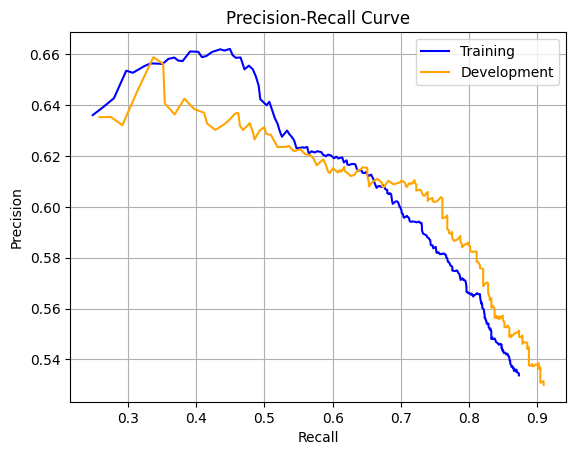

In [100]:
## TODO
# Training ～ precision-recall
twords, tlabels = train_data
thresholds = range(1000000, 30000000, 100000)
train_precisions = []
train_recalls = []
for threshold in thresholds:
  t_pred = frequency_threshold_feature(twords, threshold, ngram_counts)
  train_precisions.append(get_precision(tlabels, t_pred))
  train_recalls.append(get_recall(tlabels, t_pred))

# Development ～ precision-recall
dwords, dlabels = dev_data
dev_precisions = []
dev_recalls = []
for threshold in thresholds:
    d_pred = frequency_threshold_feature(dwords, threshold, ngram_counts)
    dev_precisions.append(get_precision(dlabels, d_pred))
    dev_recalls.append(get_recall(dlabels, d_pred))

# precision-recall curve
plt.plot(train_recalls, train_precisions, label='Training', color='blue')  # Training data in blue
plt.plot(dev_recalls, dev_precisions, label='Development', color='orange')  # Dev data in orange
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()

In [101]:
# PennGrader - DO NOT CHANGE
word_freq_pred = word_frequency_threshold(train_data, mini_test_words, ngram_counts)
grader.grade(test_case_id = 'test_baseline_q23', answer = word_freq_pred)

19900000
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Section 3. Classifiers

## 3.1 Naive Bayes classification


Now, let’s move on to actual machine learning classifiers! For our first classifier, you will use the built-in [Naive Bayes model from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html), to train a classifier. You should refer to the online sklearn documentation when you are building your classifier.

The first thing to note is that sklearn classifiers take in `numpy` arrays, rather than regular lists. You may use the [online numpy documentation](https://numpy.org/doc/stable/). To create a `numpy` list of length 5, you can use the following Python commands:

```
import numpy as np
X = np.array([1,2,3,4,5])
```


To train a classifier, you need two numpy arrays: `X_train`, an `m` by `n` array, where `m` is the number of words in the dataset, and `n` is the number of features for each word; and `Y`, an array of length `m` for the labels of each of the words.

**Before we start training models, we need to convert our texts/words into numpy arrays, i.e. making training/testing feature vectors.**

- **Problem 3.0**: Implementing `get_training_features()` and `get_test_features()` that convert train/test dataset to numpy arrays

In [27]:
%%capture
# run the following cell if you want to use count of syllabus as a feature
!pip install syllables
import syllables

In [102]:
def get_training_features(train_data, ngram_counts):
    words, y_true = train_data
    features = []
    for word in words:
        length_feature = len(word) # word length feature
        frequency_feature = ngram_counts.get(word, 0) # unigram frequency feature
        syllable_feature = syllables.estimate(word)
        features.append([length_feature, frequency_feature, syllable_feature])

    X = np.asarray(features)
    ## YOUR CODE HERE
    # TODO: calculate the mean and std of the vectorized data (X)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)

    stds[stds == 0] = 1

    # TODO: calculate the scaled data, with the mean and std you just calculated
    X_scaled = (X - means) / stds # 标准化/归一化

    Y = np.asarray(y_true)
    return X_scaled, Y, means, stds

def get_test_features(test_words, ngram_counts, means, stds):

    ## YOUR CODE HERE
    # TODO: do the similar thing, except using means and stds as given (from training data)
    features = []
    for word in test_words:
        length_feature = len(word) # word length feature
        frequency_feature = ngram_counts.get(word, 0) # unigram frequency feature
        syllable_feature = syllables.estimate(word)
        features.append([length_feature, frequency_feature, syllable_feature])

    X = np.asarray(features)
    X_scaled = (X - means) / stds # 标准化/归一化

    return X_scaled

In [103]:
# PennGrader - DO NOT CHANGE
X_train, Y_train, means, stds = get_training_features(train_data, ngram_counts)
X_dev = get_test_features(dev_data[0], ngram_counts, means, stds)

train_feats = (X_train, Y_train, means, stds)
test_feats = (X_dev)

grader.grade(test_case_id = 'test_q30_test_feature_shapes', answer = (train_feats, test_feats))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Once we have these feature arrays, we can fit a Naive Bayes classifier using the following commands:
```
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, Y)
```
Finally, to use your model to predict the labels for a set of words, you only need one numpy array: `X_test`, an `m` by `n` array, where `m` is the number of words in the test set, and `n` is the number of features for each word. Note that the `n` used here is the same as the `n` in `X_train`. Then, we can use our classifier to predict labels using the following command:

```
Y_pred = clf.predict(X_test)
```

- **Problem 3.1**: Fill in the function `naive_bayes(train_data, dev_data, ngram_counts)`. This function will train a Naive Bayes classifier on the training data using **word length** and **word frequency** as features, and returns your model’s predictions on the training data and the development data individually.
    - **NOTE**: Before training and testing a classifier, it is generally important to normalize your features. This means that you need to find the mean and standard deviation (sd) of a feature. Then, for each row, perform the following transformation: `X_scaled = (X_original - mean)/sd`. **Be sure to always use the means and standard deviations from the training data**.
    - **Optional**: You can include more features if you want to, e.g. [the count of syllabus](https://github.com/prosegrinder/python-syllables)


In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [105]:
## Trains a Naive Bayes classifier using length and frequency features
def naive_bayes(train_data, dev_data, ngram_counts):
    # TODO
    # 1. Gets the features from the training data, and trains the model
    # 2. Train model & inference on test_words
    X_train, Y, means, stds = get_training_features(train_data, ngram_counts)
    X_dev = get_test_features(dev_data, ngram_counts, means, stds) # X_dev <=> X_test

    clf = GaussianNB() # model
    clf.fit(X_train, Y) # train model
    train_pred, dev_pred = clf.predict(X_train), clf.predict(X_dev)

    return train_pred, dev_pred

- **Answer 3.1:** Please report the precision, recall, and f-score on both the training data and the development data.
```
Training Data:
Precision: 0.5070296141190548
Recall: 0.9792027729636048
F1 Score: 0.6681119432400474
```
```
Development Data:
Precision: 0.4821852731591449
Recall: 0.9712918660287081
F1 Score: 0.6444444444444445
```

In [106]:
# report train/development metrics!
dev_text, dev_labels = dev_data
train_text, train_labels = train_data

train_pred, dev_pred = naive_bayes(train_data, dev_text, ngram_counts)
train_precision = get_precision(train_labels, train_pred)
train_recall = get_recall(train_labels, train_pred)
train_f = get_fscore(train_labels, train_pred)
print('Training Data')
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f}")

dev_precision = get_precision(dev_labels, dev_pred)
dev_recall = get_recall(dev_labels, dev_pred)
dev_f = get_fscore(dev_labels, dev_pred)
# Report the precision, recall, and f-score on the development data
print('\nDevelopment Data')
print(f"Precision: {dev_precision}")
print(f"Recall: {dev_recall}")
print(f"F1 Score: {dev_f}")

Training Data
Precision: 0.5070296141190548
Recall: 0.9792027729636048
F1 Score: 0.6681119432400474

Development Data
Precision: 0.4821852731591449
Recall: 0.9712918660287081
F1 Score: 0.6444444444444445


In [107]:
# PennGrader - DO NOT CHANGE
train_pred, mini_test_pred = naive_bayes(train_data, mini_test_words, ngram_counts)
grader.grade(test_case_id = 'test_naive_bayes', answer = mini_test_pred)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 3.2 Logistic Regression
Next, you will use sklearn’s built-in Logistic Regression classifier. Again, we will use word length and word frequency as your two features. You should refer to [the online sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) when you are building your classifier. To import and use this model, use the following command:

```
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
```

- **Problem 3.2**: For this problem, you will be filling in the function `logistic_regression(train_data, dev_data, ngram_counts)`. This function will train a `Logistic Regression` classifier on the training data, and returns your model’s predictions on the training data and the development data individually.


In [108]:
## Trains a logistic regression classifier using length and frequency features
def logistic_regression(train_data, dev_data, ngram_counts):
    ## TODO
    X_train, Y, means, stds = get_training_features(train_data, ngram_counts)
    X_dev = get_test_features(dev_data, ngram_counts, means, stds) # X_dev <=> X_test

    clf = LogisticRegression() # model
    clf.fit(X_train, Y) # train model
    train_pred, dev_pred = clf.predict(X_train), clf.predict(X_dev)

    return train_pred, dev_pred

- **Answer 3.2:** Please report the precision, recall, and f-score on both the training data and the development data.
```
Training Data:
Precision: 0.7308435286542176
Recall: 0.6556903523974581
F1 Score: 0.6912302070645554
```
```
Development Data:
Precision: 0.7428571428571429
Recall: 0.6842105263157895
F1 Score: 0.7123287671232877
```

In [109]:
dev_text, dev_labels = dev_data
train_text, train_labels = train_data

train_pred, dev_pred = logistic_regression(train_data, dev_text, ngram_counts)
train_precision = get_precision(train_labels, train_pred)
train_recall = get_recall(train_labels, train_pred)
train_f = get_fscore(train_labels, train_pred)
print('Training Data')
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f}")

dev_precision = get_precision(dev_labels, dev_pred)
dev_recall = get_recall(dev_labels, dev_pred)
dev_f = get_fscore(dev_labels, dev_pred)
# Report the precision, recall, and f-score on the development data
print('\nDevelopment Data')
print(f"Precision: {dev_precision}")
print(f"Recall: {dev_recall}")
print(f"F1 Score: {dev_f}")

Training Data
Precision: 0.7308435286542176
Recall: 0.6556903523974581
F1 Score: 0.6912302070645554

Development Data
Precision: 0.7428571428571429
Recall: 0.6842105263157895
F1 Score: 0.7123287671232877


In [110]:
# PennGrader - DO NOT CHANGE
train_pred, mini_test_pred = logistic_regression(train_data, mini_test_words, ngram_counts)
grader.grade(test_case_id = 'test_logistic', answer = mini_test_pred)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 3.3 Comparing Naive Bayes and Logistic Regression
- **Answer 3.3**: After implementing Naive Bayes and Logistic Regression classifiers, you will notice that their performance is not identical, even though they are given the same data. **Write a paragraph below that discusses which model performed better on this task and what are the potential reasons.**
    - [TODO: discussion of the differences]: **Logistic Regression** outperformed **Naive Bayes** on this task, achieving an F1 score of 0.71, with a precision of 0.74 and recall of 0.68 on the development set, compared to Naive Bayes' F1 score of 0.64, precision of 0.48, and recall of 0.97. The primary reason for Logistic Regression's superior performance lies in its ability to model feature interactions and capture the relationships between features, such as token lengths and word frequencies. Naive Bayes, with its assumption of feature independence, tends to oversimplify the data, leading to a higher recall but much lower precision, as it over-predicts the positive class. Consequently, Logistic Regression provides a more balanced performance, making it more effective for this task.

# Section 4. Build your own model
Finally, the fun part! In this section, you will build your own classifier for the complex word identification task, and compare your results to that of your classmates. You will also perform an error analysis for your best performing model.

You can choose any other types of classifier, and any additional features you can think of!
- For classifiers, beyond `Naive Bayes` and `Logistic Regression`, you might consider trying `SVM`, `Decision Trees`, and `Random Forests`, among others.
- Additional word features that you might consider include number of syllables, number of `WordNet` synonyms, and number of `WordNet` senses. To use WordNet in Python, refer to [this documentation](http://www.nltk.org/howto/wordnet.html).
- You could also include sentence-based complexity features, such as length of the sentence, average word length, and average word frequency.

When trying different classifiers, we recommend that you train on training data, and test on the development data, like the previous sections.

In the following cell, please include a description of **all of the models** and **features** that you tried. To receive full credit, you MUST try **at least 1 type of classifier** (not including `Naive Bayes` and `Logistic Regression`), and **at least two features** (not including length and frequency).

**Note**: You can also tune the parameters of your model, e.g. what type of kernel to use. This is NOT required, as some of you may not be that familiar with this.

## 4.1 Your Own Model

An important part of text classification tasks is to determine what your model is getting correct, and what your model is getting wrong. For this problem, you must train your best model on the training data, and report the precision, recall, and f-score on the development data. In order to receive full credit, your model must be able to outperform all of the baselines.

- **Answer 4.1**: Train your best model on the training data, and report the precision, recall, and f-score on the development data

```
Development Data:
Precision: 0.7226720647773279
Recall: 0.854066985645933
F1 Score: 0.7828947368421051
```

**Feature one:** get the length of word tokenizer

In [111]:
# feature 1: get the length of word tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')

def get_token_feature(tokenizer, word):
    token_ids = tokenizer.encode(word, add_special_tokens=False)
    return len(token_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


**Feature two:** get the mean of the Word2Vec vector

In [112]:
from gensim.models import Word2Vec
import numpy as np

def train_word2vec(twords, vector_size=100, window=5, min_count=1):
    model = Word2Vec(sentences=[twords], vector_size=vector_size, window=window, min_count=min_count, workers=4)
    return model

def word2vector(model, word, feature_type="mean"):
    if word in model.wv:
        vector = model.wv[word]
    return np.mean(vector)

**Feature three:** NLTK

In [113]:
import nltk
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('cmudict')

def get_wordnet_info(word):
    synsets = wn.synsets(word)

    synonyms = set()
    for synset in synsets:
        for lemma in synset.lemmas():
            synonyms.add(lemma.name())

    num_senses = len(synsets)
    num_synonyms = len(synonyms)

    return num_senses, num_synonyms

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


In [114]:
def get_training_features_mymodel(train_data, ngram_counts):
    words, y_true = train_data
    features = []
    tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
    word2vec_model = train_word2vec(words, vector_size=100, window=5, min_count=1)

    for word in words:
        length_feature = len(word) # word length feature
        frequency_feature = ngram_counts.get(word, 0) # unigram frequency feature
        syllable_feature = syllables.estimate(word)
        token_feature = get_token_feature(tokenizer, word)
        word2vec_feature = word2vector(word2vec_model, word, feature_type="mean")
        num_senses, num_synonyms = get_wordnet_info(word)
        features.append([length_feature, frequency_feature, syllable_feature, token_feature, word2vec_feature, num_senses, num_synonyms])

    X = np.asarray(features)
    ## YOUR CODE HERE
    # TODO: calculate the mean and std of the vectorized data (X)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)

    stds[stds == 0] = 1

    # TODO: calculate the scaled data, with the mean and std you just calculated
    X_scaled = (X - means) / stds # 标准化/归一化

    Y = np.asarray(y_true)
    return X_scaled, Y, means, stds

def get_test_features_mymodel(test_words, ngram_counts, means, stds):

    ## YOUR CODE HERE
    # TODO: do the similar thing, except using means and stds as given (from training data)
    features = []
    tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
    word2vec_model = train_word2vec(test_words, vector_size=100, window=5, min_count=1)

    for word in test_words:
        length_feature = len(word) # word length feature
        frequency_feature = ngram_counts.get(word, 0) # unigram frequency feature
        syllable_feature = syllables.estimate(word)
        token_feature = get_token_feature(tokenizer, word)
        word2vec_feature = word2vector(word2vec_model, word, feature_type="mean")
        num_senses, num_synonyms = get_wordnet_info(word)
        features.append([length_feature, frequency_feature, syllable_feature, token_feature, word2vec_feature, num_senses, num_synonyms])

    X = np.asarray(features)
    X_scaled = (X - means) / stds # 标准化/归一化

    return X_scaled

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional, dropout=0.5)
        self.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(hidden_size * (2 if bidirectional else 1), hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        batch_size = x.size(0)
        h_0 = torch.zeros(self.lstm.num_layers * (2 if self.lstm.bidirectional else 1), batch_size, self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers * (2 if self.lstm.bidirectional else 1), batch_size, self.lstm.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h_0, c_0))
        out = out[:, -1, :]
        out = self.fc(out)
        return torch.sigmoid(out)

def train_lstm_model(train_data, dev_data, ngram_counts, input_size=100, hidden_size=128, num_layers=3, output_size=1, epochs=2000, learning_rate=0.001, patience=5):
    X_train, Y_train, means, stds = get_training_features_mymodel(train_data, ngram_counts)
    X_dev = get_test_features_mymodel(dev_data, ngram_counts, means, stds)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
    X_dev = torch.tensor(X_dev, dtype=torch.float32).unsqueeze(1)

    model = LSTMModel(input_size=X_train.shape[2], hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    best_loss = float('inf')
    trigger_times = 0
    model.train()

    for epoch in range(epochs):
        model.zero_grad()
        output = model(X_train.to(device))
        loss = criterion(output, Y_train.to(device))
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        model.eval()
        with torch.no_grad():
            val_output = model(X_dev.to(device))
            val_loss = criterion(val_output, torch.zeros_like(val_output))
            if val_loss < best_loss:
                best_loss = val_loss
                trigger_times = 0
            else:
                trigger_times += 1
        model.train()

    model.eval()
    with torch.no_grad():
        train_pred = (model(X_train.to(device)) > 0.5).cpu().numpy().astype(int)
        dev_pred = (model(X_dev.to(device)) > 0.5).cpu().numpy().astype(int)

    return train_pred, dev_pred


In [116]:
dev_text, dev_labels = dev_data
train_pred, dev_pred = train_lstm_model(train_data, dev_text, ngram_counts, input_size=100, hidden_size=128, num_layers=3, output_size=1, epochs=1000, learning_rate=0.001, patience=5)
dev_precision = get_precision(dev_labels, dev_pred)
dev_recall = get_recall(dev_labels, dev_pred)
dev_f = get_fscore(dev_labels, dev_pred)
# Report the precision, recall, and f-score on the development data
print(f"Precision: {dev_precision}")
print(f"Recall: {dev_recall}")
print(f"F1 Score: {dev_f}")

Epoch [2/1000], Loss: 0.6916
Epoch [4/1000], Loss: 0.6899
Epoch [6/1000], Loss: 0.6883
Epoch [8/1000], Loss: 0.6868
Epoch [10/1000], Loss: 0.6850
Epoch [12/1000], Loss: 0.6831
Epoch [14/1000], Loss: 0.6808
Epoch [16/1000], Loss: 0.6774
Epoch [18/1000], Loss: 0.6734
Epoch [20/1000], Loss: 0.6679
Epoch [22/1000], Loss: 0.6603
Epoch [24/1000], Loss: 0.6491
Epoch [26/1000], Loss: 0.6345
Epoch [28/1000], Loss: 0.6161
Epoch [30/1000], Loss: 0.5982
Epoch [32/1000], Loss: 0.5776
Epoch [34/1000], Loss: 0.5614
Epoch [36/1000], Loss: 0.5482
Epoch [38/1000], Loss: 0.5392
Epoch [40/1000], Loss: 0.5335
Epoch [42/1000], Loss: 0.5284
Epoch [44/1000], Loss: 0.5298
Epoch [46/1000], Loss: 0.5313
Epoch [48/1000], Loss: 0.5276
Epoch [50/1000], Loss: 0.5224
Epoch [52/1000], Loss: 0.5201
Epoch [54/1000], Loss: 0.5195
Epoch [56/1000], Loss: 0.5187
Epoch [58/1000], Loss: 0.5169
Epoch [60/1000], Loss: 0.5143
Epoch [62/1000], Loss: 0.5142
Epoch [64/1000], Loss: 0.5139
Epoch [66/1000], Loss: 0.5160
Epoch [68/1000

## 4.2 Analyze your model


Describe the model and features you choose, and perform a detailed error analysis of your models. Give several examples of words on which your best model performs well. Also give examples of words which your best model performs poorly on, and identify at least TWO categories of words on which your model is making errors.




- **Answer 4.2**: Write a detailed description of your model and features used. Also include error analysis of your model.

**Models Description**

I implement a LSTM-based model,which is designed for sequence data classification, combining recurrent neural networks with fully connected layers for binary classification tasks.

***LSTM Layer***: The core of the model is a LSTM layer, which processes sequential data and captures dependencies across time steps, making it ideal for time series or text data. The LSTM receives input in the form of sequences with dimensions [batch_size, sequence_length, input_size]. It has 128 hidden units, which allow it to learn complex patterns in the data, and it is stacked with 3 layers to increase its learning capacity.

***Fully Connected Layer***: The output from the LSTM is passed through a fully connected layer, which refines the features learned by the LSTM. This layer starts with a dropout of 0.4 for regularization, helping to prevent overfitting by randomly dropping neurons during training. Following the dropout, a LeakyReLU activation function with a negative slope of 0.01 is applied, introducing non-linearity and allowing the model to avoid issues such as the vanishing gradient.

***Forward Propagation***: In forward propagation, the model begins by initializing hidden states (h_0 and c_0) for the LSTM, ensuring the hidden states match the batch size. The input sequence is then passed through the LSTM, which processes the sequence step by step, producing a hidden state at each step. The output from the final time step is extracted and passed through the fully connected layers

<br/>

**Features Description**

***Word Length***: Represents the number of characters in each word. It can capture basic structural information that helps distinguish certain classes.

***Unigram Frequency***: The frequency of the word in the corpus. This feature helps capture the commonality or rarity of a word, which can be crucial in determining its class.<br/>

***Syllable Count***: This feature estimates the number of syllables in a given word. The syllable count provides valuable information about the word’s phonetic complexity, which can be useful for tasks related to readability, pronunciation, or linguistic analysis.<br/>

***Token Length***: This feature extracts the length of a word based on its tokenization using the BERT tokenizer. By using a pre-trained BERT model, the word is split into subword tokens, and the number of tokens is returned as a feature.<br/>

***Word2Vec Embedding Mean***: This feature leverages a pre-trained Word2Vec model to generate vector embeddings for a given word. The word is converted into its vector representation, and the mean value of the vector components is used as the feature.<br/>

***WordNet Synsets and Synonyms***: This feature extracts the number of senses and unique synonyms for a given word using WordNet. By counting the word's synsets (senses) and synonyms, it provides insight into the word's polysemy and lexical diversity.

<br/>


**Performance Analysis**
The performance comparison between Naive Bayes, Logistic Regression, and the LSTM model shows that the LSTM significantly outperforms the baseline models.  Naive Bayes tends to over-predict, leading to higher recall but low precision, which limits its effectiveness.  Logistic Regression improves the balance between precision and recall, providing a more stable baseline.  However, the LSTM model, with its ability to capture complex patterns in sequential data, achieves the best overall performance, particularly excelling in its ability to minimize misclassifications, as reflected by its superior F1 score (0.783).

<br/>

**Error Analysis**

Based on the error from output, the model tends to perform well on simple words or words that have consistent forms, such as "go" or "run."  These words typically appear frequently and have straightforward morphology.  However, the model struggles with more complex words, particularly those with irregular forms, compound words, or those involving tense changes, such as "gone" or "running."  Additionally, compound words or phrases like "self-imposed" or "long-standing" often lead to misclassification, as the model has difficulty understanding the nuances in how these are formed or used contextually.

## 4.3 Leaderboard
Finally, use your classifier to predict labels for the test data, and submit these labels in a text file named `test_labels.txt` (with one label per line) to the leaderboard; be sure NOT to shuffle the order of the test examples. Instructions for how to post to the leaderboard will be posted on Ed soon.
**In addition, the top 3 teams will receive 5 bonus points!**

In [ ]:
train_pred, test_pred = train_lstm_model(train_data, test_words, ngram_counts)
test_pred = [int(pred) for sublist in test_pred for pred in sublist]
test_pred = np.array(test_pred).flatten()
with open('test_labels.txt', 'w') as f:
    f.write("\n".join(map(str, test_pred)))

Epoch [2/2000], Loss: 0.6996
Epoch [4/2000], Loss: 0.6971
Epoch [6/2000], Loss: 0.6948
Epoch [8/2000], Loss: 0.6924
Epoch [10/2000], Loss: 0.6899
Epoch [12/2000], Loss: 0.6871
Epoch [14/2000], Loss: 0.6835
Epoch [16/2000], Loss: 0.6794
Epoch [18/2000], Loss: 0.6743
Epoch [20/2000], Loss: 0.6678
Epoch [22/2000], Loss: 0.6589
Epoch [24/2000], Loss: 0.6472
Epoch [26/2000], Loss: 0.6338
Epoch [28/2000], Loss: 0.6162
Epoch [30/2000], Loss: 0.5998
Epoch [32/2000], Loss: 0.5828
Epoch [34/2000], Loss: 0.5700
Epoch [36/2000], Loss: 0.5583
Epoch [38/2000], Loss: 0.5483
Epoch [40/2000], Loss: 0.5402
Epoch [42/2000], Loss: 0.5308
Epoch [44/2000], Loss: 0.5262
Epoch [46/2000], Loss: 0.5236
Epoch [48/2000], Loss: 0.5277
Epoch [50/2000], Loss: 0.5265
Epoch [52/2000], Loss: 0.5253
Epoch [54/2000], Loss: 0.5212
Epoch [56/2000], Loss: 0.5174
Epoch [58/2000], Loss: 0.5165
Epoch [60/2000], Loss: 0.5166
Epoch [62/2000], Loss: 0.5166
Epoch [64/2000], Loss: 0.5153
Epoch [66/2000], Loss: 0.5148
Epoch [68/2000

- **Answer 4.3**: Upload your `test_labels.txt` to the leaderboard in Gradescope.

## 4.4. (Optional) Leaderboard using outside data

While the training data we have provided is sufficient for completing this assignment, it is not the only data for the task of identifying complex words. As an optional addition to this homework, you may look for and use any additional training data, and submit your predicted labels in a text file named `test_labels.txt` to the leaderboard.

As a start, we recommend looking at the [SemEval 2016 dataset](http://alt.qcri.org/semeval2016/task11/), a dataset that was used in a complex words identification competition. In addition, you can try to use data from [Newsela](https://newsela.com/). Newsela’s editors re-write newspaper articles to be appropriate for students at different grade levels. The company has generously shared a dataset with us. The Newsela data **may not** be re-distributed outside of Penn. You can find the data on eniac at `/home1/c/ccb/data/newsela/newsela_article_corpus_with_scripts_2016-01-29.1.zip`.

Good luck, and have fun!

# Submission
Here are the deliverables that you will need to submit:
- This notebook (rename them to `homework1.ipynb` and `homework1.py`)
- Your model’s output for the test set using only the provided training and development data (`test_labels.txt`)
- (Optional) your model’s output for the test set, using any data that you want. (`test_labels.txt`)